# Introduction

This Notebook is a step for step handbook for calculating the emission factors of conventional power plants in Germany. It is based on the code from _Schubert, Tim Niclas, Avenmarg, Gabriel, Unnewehr, Jan Frederick, & Schäfer, Mirko. (2022). Generation and emission data for main power plants in Germany (2015 - 2021)_, which is available under https://doi.org/10.5281/zenodo.7316186.

This code was updated and changed to SMARD Data, especially the _blocks.xlsx_ file was updated in terms of ETS-IDs matching. 

Only plants, that are mandated to submit generation data are included. This refers to plants with a total nominal electrical power of least 200 MW or single blocks with a nominal elctrical power of at least 100 MW.

## Preparation of Python environment

The following modules and their dependencies are required to run this notebook:
* Pandas
* Numpy
* Seaborn
* Matplotlib

In [26]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import read_excel
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


## Download of input files and setup of folder structure

First we need to download and prepare the raw primary Data. For that we need three different Datasets.

- We need the _blocks.xlsx_ data, which is a list of all powerplants in Germany. It was collected by the INATECH and is available via the repository. So it isn't necessary to download it independently

- Also we need the processed Generation Data from the SMARD Website, found in the Repo here:

- Then we also need the Verified emissions from 2021 which can be downloaded here https://climate.ec.europa.eu/eu-action/eu-emissions-trading-system-eu-ets/union-registry_en#documentation Access the link, go to section *Phase IV (2021-2030)* - *Reports* and download the file *Verified Emissions for 2021*. Delete the informational rows marked in yellow. Include the file into the */input/EC* folder.

In [27]:
# INITIAL SETUP

# data is currently provided for the years of 2016 to 2021
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# import main file for German powerplant data including EIC, ETS-ID, electrical and heat power, CHP
blocks = pd.read_excel('input/blocks.xlsx')

blocks.head(10)

,ETS-ID,EIC,BNA-ID,MaStR-Nr,Name BNA,City,Plant name,Block name,CHP,Net electrical power [MW_el],Heat power [MW_th],Fuel,Fuel emission factor [t/MWh_th]
0,1399,11WD7BERG1S--A-X,BNA0067,SEE930673793902,Bergkamen A,Bergkamen,Bergkamen,A,0,717,20.0,hard coal,0.3368
1,1453,11WD8BOXB1L---N8,BNA0122,SEE985842749525,Boxberg Block N,Boxberg,Boxberg,N,1,500,30.0,lignite,0.3980
2,1453,11WD8BOXB1L---P4,BNA0123,SEE908125004449,Boxberg Block P,Boxberg,Boxberg,P,1,500,30.0,lignite,0.3980
3,1454,11WD8BOXB1L---Q2,BNA0124,SEE907389779292,Boxberg Block Q,Boxberg,Boxberg,Q,1,840,65.0,lignite,0.3980
4,1454,11WD8BOXB1L---R0,BNA1404,SEE968582186379,Boxberg Block R,Boxberg,Boxberg,R,0,630,0.0,lignite,0.3980
5,1460,11WD8LIPD1L---R6,BNA0115,SEE966331411864,Kraftwerk Lippendorf Block R,Boehlen,Lippendorf,R,1,891,230.0,lignite,0.3717
6,1460,11WD8LIPD1L---S4,BNA0116,SEE998199911088,Kraftwerk Lippendorf Block S,Boehlen,Lippendorf,S,1,891,230.0,lignite,0.3717
7,795,11WD2BURG000145R,BNA0172a,SEE947816911833,Gasturbinenanlage 12,Burghausen,Burghausen,NaN,1,120,350.0,NG,0.2010
8,1419,11WD2BUSD0000386,BNA0439,NaN,Buschhaus,Helmstedt,Buschhaus,NaN,0,352,0.0,lignite,0.3582
9,1409,11WD7HERD2G-H6-X,BNA0442,SEE942982288260,Cuno Heizkraftwerk Herdecke H6,Herdecke,Cuno HKW Herdecke,H6,1,424,0.0,NG,0.2010


First we get all unique IDs for ETS and EIC IDs out of the blocks.xlsx list

In [28]:
# GENERATION OF EIC AND ETS-ID LISTS

# list of all powerplant block EIC codes
eic_list = blocks['EIC'].unique()

# list of all powerplant location ETS-ID codes
ets_list = blocks['ETS-ID'].unique()

## Import Smard Data
For the perUnit Generation Data we use data from SMARD. The data was processed beforehand, for which exists a different notebook and repo. In this process the SMARD Date is changed in a way to make it easier to automatically process. For that mostly two things are changed:
1. The Filenames are changed so they contain _Plant Name, Year_ and _ETS-ID_, whereas before each Power Plant was just named by it's name. This made it hard to match it.
1. In each CSV File the Columns are named with the corresponding _EIC-ID_ instead of the _Block Name_. This makes it easy to access the Genration Data on a unit base and creates a consistent naming. Also all Blocks not operating anymore are deleted.

In [29]:
# READ IN THE FILEPATHS AND SAVE THEM IN A PANDAS DATAFRAME

# Folder which contains all smard data files
smard_folder = "./input/smard"
files_smard = os.listdir(smard_folder)

# Initialize columns for DataFrame, in which we save the year, the plant name and the filename
years_smard = []
plant_names_smard = []
ets_ids_smard = []
filenames = []

# Loop through all filenames, except the first, as this is the .gitignore
for filename in files_smard:
    # Split the filename on underscore, to get each information saved in the filename
    filename_array = filename.split("_")
    
    # Check if file is csv file
    if filename_array[-1].split(".")[1] != "csv":
        continue
    
    # # Get year and plant name and save them in the arrays
    years_smard.append(filename_array[2][:-4])
    plant_names_smard.append(filename_array[0])
    ets_ids_smard.append(filename_array[1])
    filenames.append(filename)

# Convert everything to a DataFrame
smard_files_df = pd.DataFrame({"filename": filenames,"year":years_smard, "plant name":plant_names_smard, "ets-id":ets_ids_smard}) 

smard_files_df.head(10)

,filename,year,plant name,ets-id
0,Bergkamen_1399_2016.csv,2016,Bergkamen,1399
1,Bergkamen_1399_2017.csv,2017,Bergkamen,1399
2,Bergkamen_1399_2018.csv,2018,Bergkamen,1399
3,Bergkamen_1399_2019.csv,2019,Bergkamen,1399
4,Bergkamen_1399_2020.csv,2020,Bergkamen,1399
5,Bergkamen_1399_2021.csv,2021,Bergkamen,1399
6,Bergkamen_1399_2022.csv,2022,Bergkamen,1399
7,Bexbach_852_2016.csv,2016,Bexbach,852
8,Bexbach_852_2017.csv,2017,Bexbach,852
9,Bexbach_852_2018.csv,2018,Bexbach,852


In [30]:
# IMPORTING THE GENERATION DATA FROM THE SMARD CSV FILES

# The columns we add to smard_generation_data_df, for each year a Columns with the Generation per Year
columns = ["EIC", "ETS-ID"] + [f'Generation elec. {y} [MWh_el]' for y in years]
smard_generation_data_df = pd.DataFrame([], columns=columns)
smard_generation_data_df["EIC"] = blocks["EIC"]
smard_generation_data_df["ETS-ID"] = blocks["ETS-ID"]

# Loop over the ETS-List and for each ETS-ID get the corresponding smard Data and calculate the yearly Generation Data
for ets_id in ets_list:

    # Get all Blocks belonging to one ETS-ID
    blocks_eic_df = blocks[blocks["ETS-ID"] == ets_id]

    # Check if DataFrame is emtpty
    if len(blocks_eic_df) == 0:
        continue

    # Loop over years to get Generation Data for each year
    for year in years:

        # With the ETS-ID get the correct csv-filename for ETS-ID and Year
        filename = smard_files_df[(smard_files_df["ets-id"] == str(ets_id)) & (smard_files_df["year"] == str(year))]["filename"].values

        if len(filename) == 0:
            continue
        filename = filename[0]
        # Read in CSV Data
        smard_data_df = pd.read_csv(f"{smard_folder}/{filename}", delimiter=",")
        amt_rows = len(smard_data_df)

        # Loop over all Blocks belonging to the csv file which are defined in th blocks dataset
        for block in blocks_eic_df.values:

            # Get EIC Id of the Block
            eic_id = block[1]

            # Try Except is used to handle possible errors when a column is not existing
            try:
                # Every Block should have 8760 or 8784 (leap year) entries because that's the amount of hours per year
                # Interpolate for entries where there is more data then 3/4 of a whole year
                if amt_rows != 8760 and amt_rows != 8784 and amt_rows > 6750:
                
                    # If that's not the given the gen_data_unit_year will be interpolated. For that the mean Generation per hours is calculated
                    # and then multiplied by the missing hours
                    leap_years = [2016, 2020]
                    gen_data_unit_year = smard_data_df[eic_id].sum()
                    mean_gen_hour = gen_data_unit_year / amt_rows

                    # Get the missing hours to a full year, for a normal or a leap year
                    if year in leap_years:
                        missing_hours = 8784 - amt_rows
                    else:
                        missing_hours = 8760 - amt_rows
                    gen_data_unit_year = gen_data_unit_year + (mean_gen_hour * missing_hours)
                    
                else:
                    gen_data_unit_year = smard_data_df[eic_id].sum()

                # Assign value to the smard_generation_data_df, where each EIC ID is a row and has a column for each year
                smard_generation_data_df[f"Generation elec. {year} [MWh_el]"].loc[smard_generation_data_df["EIC"] == eic_id] = gen_data_unit_year
            except Exception as e:
                print(e)
                continue

# Set the Index to the EIC-ID
# smard_generation_data_df = smard_generation_data_df.set_index("EIC")

smard_generation_data_df.head(20)

C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smard_generation_data_df[f"Generation elec. {year} [MWh_el]"].loc[smard_generation_data_df["EIC"] == eic_id] = gen_data_unit_year
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smard_generation_data_df[f"Generation elec. {year} [MWh_el]"].loc[smard_generation_data_df["EIC"] == eic_id] = gen_data_unit_year
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'
'11WD2S1G2000097U'
'11WD2S1G3000098K'


C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smard_generation_data_df[f"Generation elec. {year} [MWh_el]"].loc[smard_generation_data_df["EIC"] == eic_id] = gen_data_unit_year
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smard_generation_data_df[f"Generation elec. {year} [MWh_el]"].loc[smard_generation_data_df["EIC"] == eic_id] = gen_data_unit_year
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1647844679.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,EIC,ETS-ID,Generation elec. 2016 [MWh_el],Generation elec. 2017 [MWh_el],Generation elec. 2018 [MWh_el],Generation elec. 2019 [MWh_el],Generation elec. 2020 [MWh_el],Generation elec. 2021 [MWh_el],Generation elec. 2022 [MWh_el]
0,11WD7BERG1S--A-X,1399,2796586.0,1796371.0,1741338.0,740499.0,374569.0,914717.0,2025901.0
1,11WD8BOXB1L---N8,1453,3853243,3527767.0,3874468,2762964,3104985,2594696.0,3634225.0
2,11WD8BOXB1L---P4,1453,3704029,3677257.0,3560197,3674633,2501534,3260569.0,3174565.0
3,11WD8BOXB1L---Q2,1454,4942260,6814103.0,5638488,6441879,4530842,5514886.0,6243320.0
4,11WD8BOXB1L---R0,1454,4443033,3414023.0,4214045,4088166,3692609,2787492.0,4325589.0
5,11WD8LIPD1L---R6,1460,6522296,5634518.0,6369766,4841568,3355373,6334075.0,5923867.0
6,11WD8LIPD1L---S4,1460,4934454,6271119.0,5686633,4442909,5019731,4948298.0,6207170.0
7,11WD2BURG000145R,795,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,11WD2BUSD0000386,1419,1710289,0.0,0,0,0.0,0.0,0.0
9,11WD7HERD2G-H6-X,1409,429315.983471,490275.0,461604.0,991632.0,1358468.640669,1110705.0,877719.0


In [31]:
# IMPORT OF EMISSIONS AND ALLOCATION DATA

# import data on verified emissions and free emission allocations (source: EC)
EC_data = pd.read_excel('input/EC/verified_emissions_2022_en.xlsx')
EC_data = EC_data[EC_data.REGISTRY_CODE == 'DE']

# output
EC_data.head(10)

,REGISTRY_CODE,IDENTIFIER_IN_REG,INSTALLATION_NAME,INSTALLATION_IDENTIFIER,PERMIT_IDENTIFIER,MAIN_ACTIVITY_TYPE_CODE,ALLOCATION_2022,ALLOCATION_RESERVE_2022,ALLOCATION_TRANSITIONAL_2022,CH_ALLOCATION_2022,...,VERIFIED_EMISSIONS_2012,ALLOCATION_2011,VERIFIED_EMISSIONS_2011,ALLOCATION_2010,VERIFIED_EMISSIONS_2010,ALLOCATION_2009,VERIFIED_EMISSIONS_2009,ALLOCATION2008,VERIFIED_EMISSIONS_2008,ACCOUNT_CLOSURE
1184,DE,ADM Mainz GmbH,0010 Feuerungsanlage (Kesselhaus),975,14310-0397,20,32443,0,0,-1,...,60208,54405,61396,54405,62035,54405,59673,54405,65131,OPEN
1185,DE,Eurowings GmbH,2034,207497,19550-0693,10,-1,-1,-1,17225,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1186,DE,AIR-INDIA-AOHA,237,207544,19550-0727,10,44,0,0,-1,...,146,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1187,DE,Cathay Pacific Airways Limited,5800,201533,19550-0737,10,6804,0,0,-1,...,38041,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1188,DE,Handelskonto der Trevo Aviation Ltd.,37070,200816,19550-0115,10,23,0,0,-1,...,712,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1189,DE,CargoLogic Germany GmbH,46300,215501,19550-0711,10,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,28-FEB-23
1190,DE,Emirates,9807,201598,19550-0733,10,13403,0,0,-1,...,39515,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1191,DE,SunExpress ETS holding account,10201,200479,19550-0241,10,1509,0,0,-1,...,468225,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1192,DE,PEGASUS HAVA TASIMACILIGI A.S.,10690,200541,19550-0237,10,1259,0,0,-1,...,2225,-1,-1,-1,-1,-1,-1,-1,-1,OPEN
1193,DE,Luxaviation Germany GmbH,114,212160,19550-0712,10,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,OPEN


In [32]:
# AGGREGATION TO PLANT LEVEL

# iterate through ETS-IDs and aggregate the data
installations = []
#print(len(ets_list))
for id in ets_list:
    # extract raw data
    id_data_raw = blocks.loc[blocks['ETS-ID']==id]
    id_data = dict()
    id_data['ETS-ID'] = id
    id_data['City'] = id_data_raw['City'].iloc[0]
    id_data['Plant name'] = id_data_raw['Plant name'].iloc[0]
    # nominal heat and electricity power of the blocks get summed
    id_data['Net electrical power [MW_el]'] = id_data_raw['Net electrical power [MW_el]'].sum()
    id_data['Heat power [MW_th]'] = id_data_raw['Heat power [MW_th]'].sum()
    # if one block of the plant uses CHP, the whole plant is marked as CHP plant
    id_data['CHP'] = id_data_raw['CHP'].any()
    # differentiation between single and mixed fuel type plants
    fuels = id_data_raw['Fuel'].unique()
    fuel = fuels[0] if len(fuels)==1 else 'mixed'
    id_data['Fuel'] = fuel
    if fuel == 'mixed':
        id_data['Thermal fuel emission factor [t/MWh_th]'] = np.NaN
    else:
        id_data['Thermal fuel emission factor [t/MWh_th]'] = id_data_raw['Fuel emission factor [t/MWh_th]'].iloc[0]

    for y in years:
        # generation and calculated emissions of the blocks get summed
        gen_id_y = smard_generation_data_df[smard_generation_data_df["ETS-ID"] == id][f'Generation elec. {y} [MWh_el]'].values
        if len(gen_id_y) == 0: 
            gen_id_y = np.nan
        else:
            gen_id_y = sum(gen_id_y)
        id_data['Generation elec. ' + str(y) + ' [MWh_el]'] = gen_id_y
    
    installations.append(id_data)
installations = pd.DataFrame(installations)

# output
installations.head(20)

,ETS-ID,City,Plant name,Net electrical power [MW_el],Heat power [MW_th],CHP,Fuel,Thermal fuel emission factor [t/MWh_th],Generation elec. 2016 [MWh_el],Generation elec. 2017 [MWh_el],Generation elec. 2018 [MWh_el],Generation elec. 2019 [MWh_el],Generation elec. 2020 [MWh_el],Generation elec. 2021 [MWh_el],Generation elec. 2022 [MWh_el]
0,1399,Bergkamen,Bergkamen,717,20.0,False,hard coal,0.3368,2.796586e+06,1796371.0,1.741338e+06,740499.0,3.745690e+05,9.147170e+05,2.025901e+06
1,1453,Boxberg,Boxberg,1000,60.0,True,lignite,0.3980,7.557272e+06,7205024.0,7.434665e+06,6437597.0,5.606519e+06,5.855265e+06,6.808790e+06
2,1454,Boxberg,Boxberg,1470,65.0,True,lignite,0.3980,9.385293e+06,10228126.0,9.852533e+06,10530045.0,8.223451e+06,8.302378e+06,1.056891e+07
3,1460,Boehlen,Lippendorf,1782,460.0,True,lignite,0.3717,1.145675e+07,11905637.0,1.205640e+07,9284477.0,8.375104e+06,1.128237e+07,1.213104e+07
4,795,Burghausen,Burghausen,120,350.0,True,NG,0.2010,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
5,1419,Helmstedt,Buschhaus,352,0.0,False,lignite,0.3582,1.710289e+06,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
6,1409,Herdecke,Cuno HKW Herdecke,424,0.0,True,NG,0.2010,4.293160e+05,490275.0,4.616040e+05,991632.0,1.358469e+06,1.110705e+06,8.777190e+05
7,208968,Datteln,Datteln,1052,380.0,True,hard coal,0.3368,0.000000e+00,1.0,0.000000e+00,1495.0,2.275756e+06,3.027714e+06,2.287448e+06
8,1485,Dormagen,Dormagen,586,480.0,True,NG,0.2010,1.290593e+06,947435.0,6.211110e+05,846733.0,7.270810e+05,5.238800e+05,3.892900e+05
9,1411,Hamborn,Duisburg-Hamborn,100,0.0,True,BFG,0.9319,3.695299e+05,468126.0,4.573322e+05,425450.0,4.339294e+05,1.698010e+05,5.099360e+05


In [33]:
# ACCESSING VERIFIED EMISSION AND ALLOCATION DATA

# iterate through ETS-IDs to access verified emissions and free allocations
for y in years:
    for id in ets_list:
        row = EC_data.loc[EC_data['INSTALLATION_IDENTIFIER']==id]
        if row.empty:
            allocation = None
            emissions = None
        else:
            # access allocation and emission data
            allocation = row['ALLOCATION_'+str(y)].values[0]
            emissions = row['VERIFIED_EMISSIONS_'+str(y)].values[0]
            # access generation data for reference
            generation = installations.loc[installations['ETS-ID']==id, 'Generation elec. ' + str(y) + ' [MWh_el]'].values[0]

            # processing of missing entries (-1)
            # if generation is zero, the missing values are caused by the plant not being operational, thus missing are set to zero
            if emissions==-1 and generation==0:
                    emissions = 0
            if allocation==-1 and generation==0:
                    allocation = 0

        installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'] = allocation
        installations.loc[installations['ETS-ID']==id, 'Emissions '+str(y)+' [t]'] = emissions
    
# processing of missing entries (-1)
# if only one missing entry per installation is found, this is most likely caused by the plant being practically no longer operational with generation close to zero
# in these cases, missing allocation data is set to zero
for id in ets_list:
    count_missing = 0
    for y in years:
        if installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0] == -1:
            count_missing +=1
    if count_missing == 1:
        for y in years:
            if installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0] == -1:
                installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'] = 0

# use NaN for missing values instead of -1 for calculation purposes
installations.replace(-1, np.NaN, inplace=True)

# output
columns = ['ETS-ID'] + ['Allocation ' + str(y) + " [t]" for y in years] + ['Emissions ' + str(y) + " [t]" for y in years]
installations.loc[:,columns].head(10)

,ETS-ID,Allocation 2016 [t],Allocation 2017 [t],Allocation 2018 [t],Allocation 2019 [t],Allocation 2020 [t],Allocation 2021 [t],Allocation 2022 [t],Emissions 2016 [t],Emissions 2017 [t],Emissions 2018 [t],Emissions 2019 [t],Emissions 2020 [t],Emissions 2021 [t],Emissions 2022 [t]
0,1399,2805.0,0.0,0.0,0.0,0.0,NaN,NaN,2823880.0,1639651.0,1586512.0,704134.0,348234.0,849908.0,1989681.0
1,1453,7601.0,6280.0,5307.0,4366.0,3458.0,5627.0,5483.0,8874695.0,8552606.0,8791054.0,7606935.0,6648578.0,6974582.0,7996566.0
2,1454,0.0,3669.0,3101.0,2551.0,1011.0,375.0,366.0,9696702.0,10583101.0,10209765.0,11046608.0,8736511.0,8559191.0,11131400.0
3,1460,113174.0,97553.0,82439.0,67813.0,53712.0,48435.0,47191.0,10781907.0,11376121.0,11711105.0,8943673.0,8272543.0,11051209.0,11911240.0
4,795,437870.0,429831.0,421793.0,413754.0,405716.0,194858.0,189851.0,684752.0,688971.0,664276.0,521038.0,560948.0,580468.0,538142.0
5,1419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1798498.0,3.0,127.0,48.0,0.0,0.0,0.0
6,1409,4692.0,4045.0,3419.0,2812.0,2228.0,1334.0,1300.0,188248.0,192392.0,182013.0,375089.0,532144.0,409898.0,357317.0
7,208968,0.0,NaN,0.0,NaN,NaN,848.0,826.0,0.0,152770.0,6604.0,38028.0,1959460.0,3815258.0,3823696.0
8,1485,439645.0,429592.0,419613.0,409704.0,399874.0,163080.0,158890.0,1585620.0,1388788.0,1060583.0,1229238.0,1123777.0,1063848.0,973948.0
9,1411,167596.0,164519.0,161443.0,158366.0,155289.0,40161.0,39129.0,2070524.0,2001687.0,1948081.0,1999936.0,1976698.0,1481644.0,1872039.0


# Separation of electricity and heat related emissions

Based on the regulation of the EU European Trading Scheme, electricity and heat emissions can be separated. Linear reduction factor and carbon leakage exposure factor are calculated. In combination with the ETS verified emissions, the share of carbon leakage related emissions "sigma" is be calculated.

In [34]:
# CALCULATION OF SIGMA
# define combinations of consecutive years
years_cons = [[y, y+1] for y in years][:-2]

# Save Sigmas with larges changes in between years for better understanding of Data
sigmas_changes = []

for id in ets_list:
    sigma = np.NaN
    sigma_list = dict()
    # calculation of sigma for each powerplant and set of consecutive years
    for y in years_cons:
        # 2013 is defined as the base year in the EU ETS regulations
        k_0 = y[0] - 2013
        k_1 = y[1] - 2013
        # calculation of linear reduction factors
        lrf_0 = 1 - 0.0174*k_0 if y[0]<=2020 else 0.8782 - 0.022*k_0
        lrf_1 = 1 - 0.0174*k_1 if y[1]<=2020 else 0.8782 - 0.022*k_1
        # calculation of carbon leakage exposure factors
        clef_0 = 0.8 - (0.5/7)*k_0
        clef_1 = 0.8 - (0.5/7)*k_1
        # extraction of emission allocations
        alloc_0 =  installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y[0])+' [t]'].values[0]
        alloc_1 =  installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y[1])+' [t]'].values[0]
        #print(alloc_1)
        # calculation of sigma
        if alloc_0 == 0 and alloc_1 == 0:
            sigma_y = 0
        elif alloc_0 == -1 or alloc_1 == -1:
            print("Allocation not defined")
        else:
            sigma_y = (alloc_0*lrf_1*clef_1 - alloc_1*lrf_0*clef_0)/(alloc_1*lrf_0*(1-clef_0) - alloc_0*lrf_1*(1-clef_1))
        sigma_list[str(y)] = sigma_y
        
    # special case for zero heat emissions over all years
    if all(sigma_y == 0 for sigma_y in sigma_list.values()):
        sigma = 0
        installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma
        continue

    # zeros are removed since they typically occur when the plant is not operational, nan values are removed
    sigma_list = {y:sigma_y for y,sigma_y in sigma_list.items() if sigma_y!=0}
    sigma_list = {y:sigma_y for y,sigma_y in sigma_list.items() if str(sigma_y)!='nan'}
    
    #print(sigma_list)
    # iterate through consecutive sigma values and identify occasions with a small deviation
    success = False
    for y_1, sigma_1 in sorted(list(sigma_list.items()), key=lambda x:x[0].lower(), reverse=True):
        # define years and sigmas for consecutive values
        y_1_list = str.split(y_1[1:-1], sep=',')
        y_1_list = [int(x.strip(' ')) for x in y_1_list]
        y_0_list = [x-1 for x in y_1_list]
        if str(y_0_list) in sigma_list.keys():
            sigma_0 = sigma_list[str(y_0_list)]
        else:
            continue
        
        # conditions: max. 10% relative difference or max. 0.01 absolute difference
        if abs(1-(sigma_1/sigma_0)) <= 0.1 or abs(sigma_1-sigma_0) <= 0.01:
            # calculation of the average sigma
            sigma_avg = (sigma_0+sigma_1)/2

            # only allow realistic values between 0 and 1
            if sigma_avg >= 0 and sigma_avg <= 1:
                sigma = sigma_avg
                success = True
            
            # round values slightly below 0 to 0 and values slightly above 1 to 1
            elif sigma_avg < 0 and sigma_avg >= -0.1:
                sigma = 0
                success = True
            elif sigma_avg > 1 and sigma_avg <= 1.1:
                sigma = 1
                success = True
        
        # Save sigmas which changed more tha 10%
        else:
            sigma_changed_row = [id, y, sigma_0, sigma_1]
            sigmas_changes.append(sigma_changed_row)
        if success:
            installations.loc[installations['ETS-ID']==id, 'Sigma year'] = y_0_list[1]
            installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma
            #break
    
    installations.loc[installations['ETS-ID']==id, 'Sigma'] = sigma

sigma_changed_df = pd.DataFrame(sigmas_changes, columns=["ETS-ID", "Year", "Sigma_0", "Sigma_1"])
#sigma_changed_df.to_csv('output/sigma-changed.csv', float_format="%.3f", index=False)
sigma_changed_df.head(20)
# output
columns = ['ETS-ID', 'Sigma']
installations.loc[:,columns].head(10)

,ETS-ID,Sigma
0,1399,NaN
1,1453,0.000053
2,1454,0.000222
3,1460,0.000225
4,795,1.000000
5,1419,0.000000
6,1409,0.000874
7,208968,NaN
8,1485,0.937375
9,1411,1.000000


In [35]:
# CALCULATION OF ANNUAL HEAT GENERATION AND HEAT/ELECTRICITY-RELATED EMISSIONS

# definition of heat benchmark
hb = 0.22428 # in t/MWh_th, original value 62,3 t/TJ

# iterate through years and powerplant locations to calculate the heat generation from the allocation data
for id in ets_list:
    for y in years:
        # preparation of linear reduction factor, carbon leakage exposure factor, emission allocations and sigma
        k = y - 2013
        lrf = 1 - 0.0174*k if y<=2020 else 0.8782 - 0.022*k
        clef = 0.8 - (0.5/7)*k
        alloc = installations.loc[installations['ETS-ID']==id, 'Allocation '+str(y)+' [t]'].values[0]
        sigma = installations.loc[installations['ETS-ID']==id, 'Sigma'].values[0]

        # calculation of annual heat generation
        gen_heat = alloc / (hb * lrf * (sigma + (1 - sigma) * clef))

        # calculation of annual heat-related emissions
        em_heat = gen_heat * hb

        # calculation of annual electricity-related emissions
        em_total = installations.loc[installations['ETS-ID']==id, 'Emissions '+str(y)+' [t]'].values[0]
        em_elec = em_total - em_heat

        installations.loc[installations['ETS-ID']==id, 'Generation heat ' + str(y) + ' [MWh_th]'] = gen_heat
        installations.loc[installations['ETS-ID']==id, 'Emissions (heat) ' + str(y) + ' [t]'] = em_heat
        installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) ' + str(y) + ' [t]'] = em_elec

# output
columns = ['ETS-ID', 'Sigma'] + ['Generation heat ' + str(y) + " [MWh_th]" for y in years] + ['Emissions (heat) ' + str(y) + " [t]" for y in years] + ['Emissions (elec.) ' + str(y) + " [t]" for y in years]
installations.loc[:,columns].head(10)

,ETS-ID,Sigma,Generation heat 2016 [MWh_th],Generation heat 2017 [MWh_th],Generation heat 2018 [MWh_th],Generation heat 2019 [MWh_th],Generation heat 2020 [MWh_th],Generation heat 2021 [MWh_th],Generation heat 2022 [MWh_th],Emissions (heat) 2016 [t],...,Emissions (heat) 2020 [t],Emissions (heat) 2021 [t],Emissions (heat) 2022 [t],Emissions (elec.) 2016 [t],Emissions (elec.) 2017 [t],Emissions (elec.) 2018 [t],Emissions (elec.) 2019 [t],Emissions (elec.) 2020 [t],Emissions (elec.) 2021 [t],Emissions (elec.) 2022 [t]
0,1399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1453,0.000053,6.104657e+04,5.851579e+04,5.851875e+04,5.851465e+04,5.851481e+04,1.562880e+05,2.286506e+05,13691.525797,...,13123.700980,35052.264382,51281.758716,8.861003e+06,8.539482e+06,8.777929e+06,7.593811e+06,6.635454e+06,6.939530e+06,7.945284e+06
2,1454,0.000222,0.000000e+00,3.418157e+04,3.418657e+04,3.417964e+04,1.710098e+04,1.040957e+04,1.524904e+04,0.000000,...,3835.408655,2334.658402,3420.055727,9.696702e+06,1.057543e+07,1.020210e+07,1.103894e+07,8.732676e+06,8.556856e+06,1.112798e+07
3,1460,0.000225,9.088337e+05,9.088319e+05,9.088343e+05,9.085891e+05,9.085272e+05,1.344485e+06,1.966134e+06,203833.219576,...,203764.471434,301541.115707,440964.453694,1.057807e+07,1.117229e+07,1.150727e+07,8.739895e+06,8.068779e+06,1.074967e+07,1.147028e+07
4,795,1.000000,2.059861e+06,2.059859e+06,2.059862e+06,2.059859e+06,2.059862e+06,1.237277e+06,1.244474e+06,461985.650981,...,461985.880210,277496.439761,279110.555719,2.227663e+05,2.269858e+05,2.022902e+05,5.905274e+04,9.896212e+04,3.029716e+05,2.590314e+05
5,1419,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,1.798498e+06,3.000000e+00,1.270000e+02,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00
6,1409,0.000874,3.766141e+04,3.766132e+04,3.766144e+04,3.763514e+04,3.762922e+04,3.694907e+04,5.397475e+04,8446.700861,...,8439.482555,8286.936626,12105.455896,1.798013e+05,1.839453e+05,1.735663e+05,3.666482e+05,5.237045e+05,4.016111e+05,3.452115e+05
7,208968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1485,0.937375,2.123299e+06,2.123299e+06,2.123299e+06,2.123277e+06,2.123280e+06,1.088063e+06,1.099563e+06,476213.510438,...,476209.314173,244030.742160,246610.013531,1.109406e+06,9.125744e+05,5.843695e+05,7.530294e+05,6.475677e+05,8.198173e+05,7.273380e+05
9,1411,1.000000,7.884178e+05,7.884167e+05,7.884205e+05,7.884194e+05,7.884183e+05,2.550076e+05,2.564907e+05,176826.334670,...,176826.463220,57193.107377,57525.727727,1.893698e+06,1.824861e+06,1.771254e+06,1.823109e+06,1.799872e+06,1.424451e+06,1.814513e+06


# Emission factors

The yearly installation-specific emission factor is calculated using electricity-related emissions and generation data. Annual emission factors are plotted grouped by individual installations and by fuel type

## Calculation of annual emission factors

In [36]:
# CALCULATION OF EMISSION FACTOR

# iterate through years and installations to calculate the emission factors
for id in ets_list:
    em_fac_list = []
    total_gen = 0
    total_em = 0
    for y in years:
        # access generation and emission data
        gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) '+str(y)+' [t]'].values[0]

        # calculation of annual emission factor
        if em_elec == 0 or gen == 0:
            em_fac = np.NaN
        else:
            em_fac = em_elec / gen
        em_fac_list.append(em_fac)
        installations.loc[installations['ETS-ID']==id, 'Emission factor ' + str(y) + ' [t/MWh_el]'] = em_fac

        # sums for average emission factor
        total_gen += gen 
        total_em += em_elec
    # calculation of average emission factor
    em_fac_avg = total_em / total_gen
    installations.loc[installations['ETS-ID']==id, 'Emission factor avg. [t/MWh_el]'] = em_fac_avg

# output
columns = ['ETS-ID', 'Sigma', 'Emission factor avg. [t/MWh_el]'] + ['Emission factor ' + str(y) + " [t/MWh_el]" for y in years]
installations.loc[:,columns].head(10)

C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\2457791618.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  em_fac_avg = total_em / total_gen


,ETS-ID,Sigma,Emission factor avg. [t/MWh_el],Emission factor 2016 [t/MWh_el],Emission factor 2017 [t/MWh_el],Emission factor 2018 [t/MWh_el],Emission factor 2019 [t/MWh_el],Emission factor 2020 [t/MWh_el],Emission factor 2021 [t/MWh_el],Emission factor 2022 [t/MWh_el]
0,1399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1453,0.000053,1.178815,1.172514,1.185212,1.180676,1.179603,1.183525,1.185178,1.166916
2,1454,0.000222,1.042330,1.033181,1.033956,1.035480,1.048328,1.061923,1.030651,1.052898
3,1460,0.000225,0.945020,0.923305,0.938403,0.954453,0.941345,0.963424,0.952784,0.945531
4,795,1.000000,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1419,0.000000,1.051680,1.051575,NaN,NaN,NaN,NaN,NaN,NaN
6,1409,0.000874,0.380174,0.418809,0.375188,0.376007,0.369742,0.385511,0.361582,0.393305
7,208968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1485,0.937375,1.038903,0.859610,0.963205,0.940846,0.889335,0.890640,1.564895,1.868371
9,1411,1.000000,4.358258,5.124612,3.898226,3.873014,4.285132,4.147844,8.388943,3.558316


## Analysis and plotting

In [37]:
# DATA PREPARATION
# define unique fuel types
fuel_types = list(installations['Fuel'].unique())
fuel_types.remove('mixed')

# create long format DataFrame containing ETS-ID, Fuel Type, Year, Emission factors
em_data_raw = installations[installations['Emission factor avg. [t/MWh_el]'].notna()]
em_data = []
for id in em_data_raw['ETS-ID'].unique():
    for y in years:
        em_data_y = []
        em_data_y.append(id)
        em_data_y.append(y)
        em_data_y.append(em_data_raw.loc[em_data_raw['ETS-ID']==id, 'Fuel'].values[0])
        em_data_y.append(em_data_raw.loc[em_data_raw['ETS-ID']==id, 'Emission factor '+str(y)+' [t/MWh_el]'].values[0])
        em_data.append(em_data_y)
em_data = pd.DataFrame(em_data, columns=['ETSID', 'Year', 'Fuel', 'Emission factor [t/MWh_el]'])
em_data = em_data[em_data['Emission factor [t/MWh_el]'].notna()]


In [38]:
# CALCULATION OF AVERAGE EMISSION FACTOR PER FUEL TYPE

em_fac_avg = dict()
for f in fuel_types:
    total_gen = 0
    total_em_elec = 0
    for id in ets_list:
        # filter by fuel type
        if installations.loc[installations['ETS-ID']==id]['Fuel'].values[0] == f:
            for y in years:
                # access generation and emission data
                gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
                em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) '+str(y)+' [t]'].values[0]
                # add values to fuel type-specific sum
                if str(gen)!='nan' and str(em_elec)!='nan':
                    total_gen += gen
                    total_em_elec += em_elec
                    
    # calculate average emission factor
    if total_gen > 0:
        em_fac_avg[f] = total_em_elec / total_gen
    else:
        em_fac_avg[f] = np.NaN
    
# output
print("Average emission factors per fuel type:")
for f in fuel_types:
    print(f + ": " + str(round(em_fac_avg[f],2)) + " t/MWh_el")

Average emission factors per fuel type:
hard coal: 1.08 t/MWh_el
lignite: 1.18 t/MWh_el
NG: 0.43 t/MWh_el
BFG: 2.97 t/MWh_el
crude oil: 1.02 t/MWh_el
heavy fuel oil: 1.68 t/MWh_el
light fuel oil: nan t/MWh_el


In [39]:
# SETUP FOR PLOTTING
sns.set(font_scale = 1.25)
rcParams['figure.figsize'] = 15,8

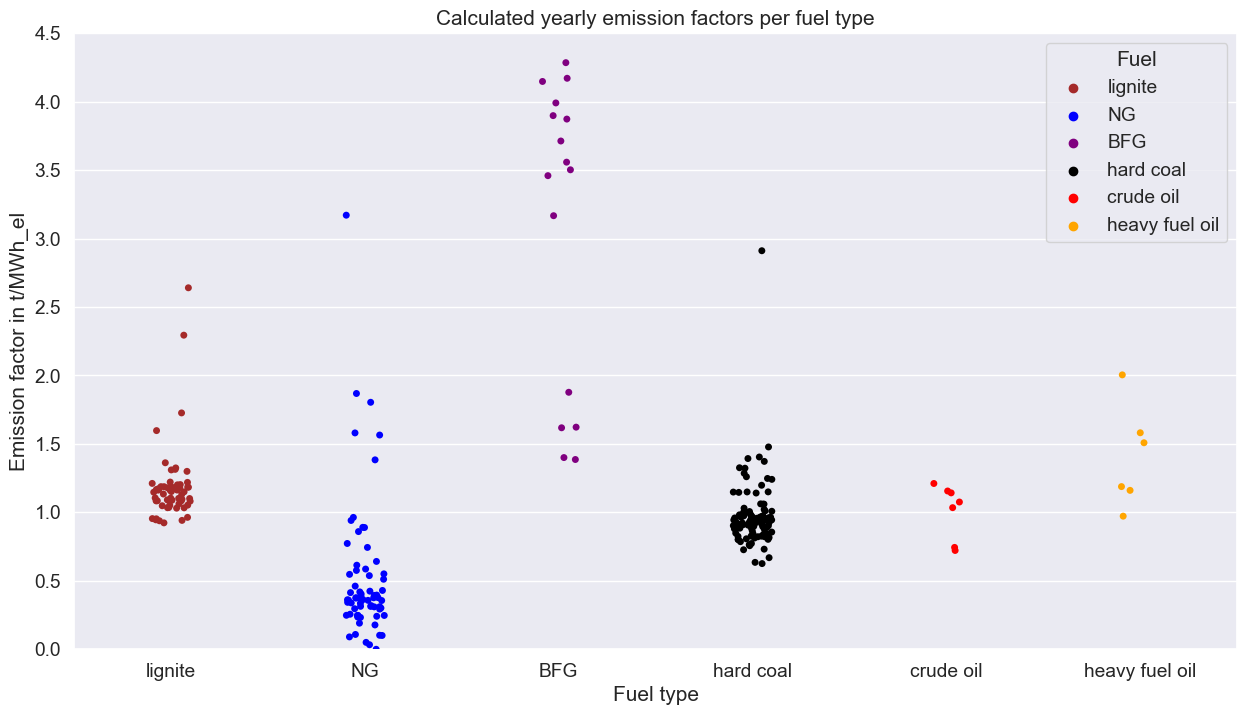

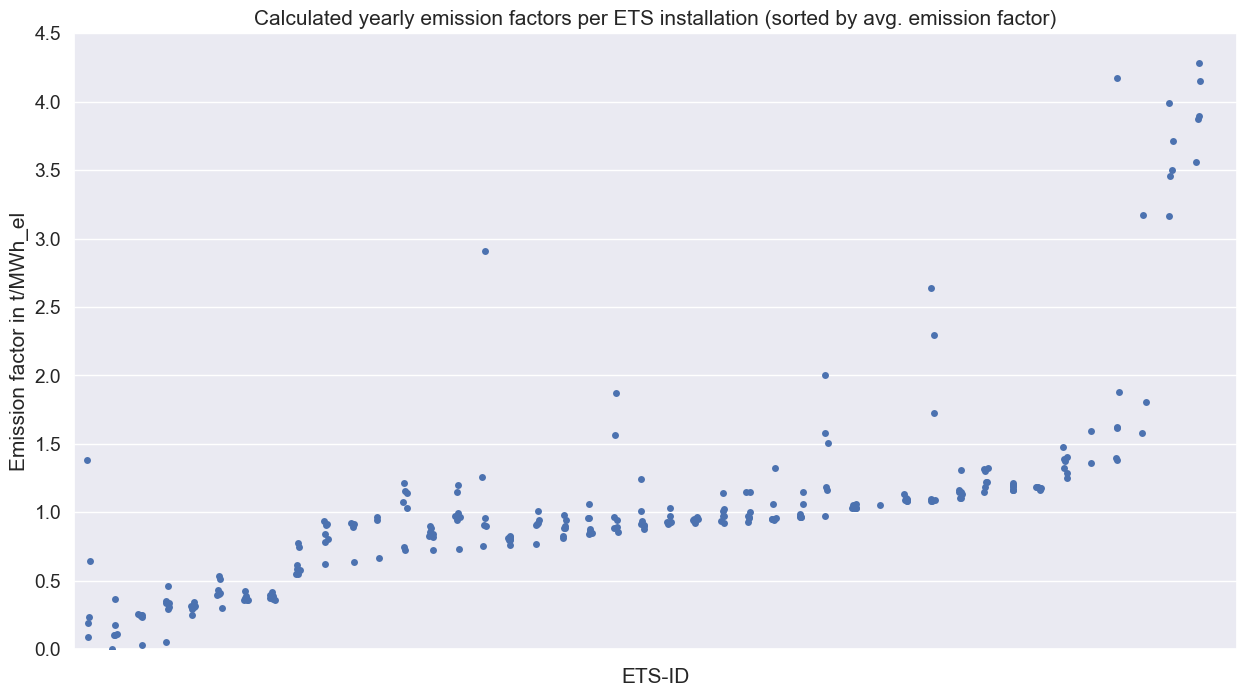

In [40]:
# PLOTTING OF EMISSION FACTORS

# for plotting purposes, mixed fuel type plants are exluded
em_data_plot = em_data.loc[em_data['Fuel']!='mixed']
# color palette for fuel types
colors_ft = {'crude oil': 'red', 'NG': 'blue', 'hard coal': 'black', 'BFG': 'purple', 'lignite': 'brown', 'heavy fuel oil': 'orange', 'light fuel oil': 'green'}

# yearly emission factors grouped by fuel type
em_plot = sns.stripplot(data=em_data_plot, x='Fuel', hue="Fuel", y='Emission factor [t/MWh_el]', palette=colors_ft)
em_plot.set(title="Calculated yearly emission factors per fuel type", ylim=(0, 4.5), xlabel='Fuel type', ylabel='Emission factor in t/MWh_el')
plt.savefig('output/plots/emission_factor-fuel_type.png')
plt.show()

# yearly emission factors grouped by individual installations
em_plot = sns.stripplot(data=em_data_plot, x='ETSID', y='Emission factor [t/MWh_el]', order=em_data_plot.sort_values('Emission factor [t/MWh_el]').ETSID.unique())
em_plot.set(title="Calculated yearly emission factors per ETS installation (sorted by avg. emission factor)", ylim=(0, 4.5), xticklabels=[], xlabel='ETS-ID', ylabel='Emission factor in t/MWh_el')
plt.savefig('output/plots/emission_factor-ETSID.png')
plt.show()

# Utilization ratio

The "Umweltbundesamt" provides thermal, fuel-specific/fuel-mix specific emission factors. In combination with the installation-specifc emission factors calculated above, the utilization ratio of each installation can be calculated.
<br><br>
Overview of emission factors (in t CO2 / MWh):
* Natural gas (NG): 0.2010
* Hard coal: 0.3368
* Lignite: Different values for the German mining areas of "Rheinland", "Lausitz", "Mitteldeutschland" and "Helmstedt"
* Oil: Different values for crude oil, light fuel oil and heavy fuel oil
* Blast furnace gas (BFG): 0.9319

<br>
Full source: Juhrich, K. & Umweltbundesamt, Fachgebiet Emissionssituation. (2009, June). CO2-Emissionsfaktoren für fossile Brennstoffe - Aktualisierung 2022. Climate Change, 28/2022, Article ISSN 1862-4359. https://www.umweltbundesamt.de/publikationen/co2-emissionsfaktoren-fuer-fossile-brennstoffe-0

## Calculation of annual utilization ratio

In [41]:
# CALCULATION OF UTILIZATION FACTOR

# iterate through years and locations to calculate the utilization factors
for id in ets_list:
    utilization_list = []
    gen_total = 0
    em_total = 0
    ff_total = 0
    for y in years:
        # access data
        gen = installations.loc[installations['ETS-ID']==id, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) '+str(y)+' [t]'].values[0]
        fuel_fac_th = installations.loc[installations['ETS-ID']==id, 'Thermal fuel emission factor [t/MWh_th]'].values[0]
        
        # calculation of utilization ratio
        utilization = fuel_fac_th / (em_elec / gen)
        utilization_list.append(utilization)
        installations.loc[installations['ETS-ID']==id, 'Utilization ratio ' + str(y) + ' [MWh_el/MWh_th]'] = utilization

        # sums for average utilization ratio
        gen_total += gen
        em_total += em_elec
        ff_total += fuel_fac_th
    # calculate average utilization ratio
    utilization_avg = ff_total / (em_total / gen_total)
    installations.loc[installations['ETS-ID']==id, 'Utilization ratio avg. [MWh_el/MWh_th]'] = utilization_avg

# output
columns = ['ETS-ID', 'Sigma', 'Emission factor avg. [t/MWh_el]', 'Utilization ratio avg. [MWh_el/MWh_th]'] + ['Utilization ratio ' + str(y) + " [MWh_el/MWh_th]" for y in years]
installations.loc[:,columns].head(10)

C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1377163429.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  utilization = fuel_fac_th / (em_elec / gen)
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1377163429.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  utilization_avg = ff_total / (em_total / gen_total)
C:\Users\yanni\AppData\Local\Temp\ipykernel_14280\1377163429.py:16: RuntimeWarning: invalid value encountered in scalar divide
  utilization = fuel_fac_th / (em_elec / gen)


,ETS-ID,Sigma,Emission factor avg. [t/MWh_el],Utilization ratio avg. [MWh_el/MWh_th],Utilization ratio 2016 [MWh_el/MWh_th],Utilization ratio 2017 [MWh_el/MWh_th],Utilization ratio 2018 [MWh_el/MWh_th],Utilization ratio 2019 [MWh_el/MWh_th],Utilization ratio 2020 [MWh_el/MWh_th],Utilization ratio 2021 [MWh_el/MWh_th],Utilization ratio 2022 [MWh_el/MWh_th]
0,1399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1453,0.000053,1.178815,2.363389,0.339442,0.335805,0.337095,0.337402,0.336284,0.335815,0.341070
2,1454,0.000222,1.042330,2.672858,0.385218,0.384929,0.384363,0.379652,0.374792,0.386164,0.378004
3,1460,0.000225,0.945020,2.753275,0.402576,0.396098,0.389438,0.394861,0.385811,0.390120,0.393112
4,795,1.000000,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1419,0.000000,1.051680,2.384186,0.340632,0.000000,0.000000,0.000000,NaN,NaN,NaN
6,1409,0.000874,0.380174,3.700938,0.479933,0.535731,0.534565,0.543622,0.521386,0.555890,0.511053
7,208968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1485,0.937375,1.038903,1.354313,0.233827,0.208678,0.213638,0.226012,0.225680,0.128443,0.107580
9,1411,1.000000,4.358258,1.496768,0.181848,0.239057,0.240614,0.217473,0.224671,0.111087,0.261894


# Output

Additionally to the block-wise input file, three output files are generated:
* Block-wise (long format): Yearly generation
* Installation-wise (wide format): Plant information overview containing fuel type, sigma, heat share, avg. emission factor
* Installation-wise (long format): Detailed yearly values including heat/electricity generation, emissions, emission factor, ...

In [42]:
# PREPARE BLOCK-WISE LONG FORMAT (GENERATION DATA)

out_block = []
for eic in eic_list:
    for y in years:
        # access generation information
        gen = smard_generation_data_df.loc[smard_generation_data_df['EIC']==eic, 'Generation elec. '+str(y)+' [MWh_el]'].values[0]
        bna = blocks.loc[blocks['EIC']==eic, 'BNA-ID'].values[0]
        bna_name = blocks.loc[blocks['EIC']==eic, 'Name BNA'].values[0]
        plant_name = blocks.loc[blocks['EIC']==eic, 'Plant name'].values[0]
        block_name = str(blocks.loc[blocks['EIC']==eic, 'Block name'].values[0]) if str(blocks.loc[blocks['EIC']==eic, 'Block name'].values[0])!='nan' else ""
        name = plant_name + " " + block_name
        # store information
        out_block.append([eic, bna, bna_name, name, y, gen])
# convert to DataFrame
out_block = pd.DataFrame(out_block, columns=['EIC', 'BNA-ID', 'Name BNA', 'Plant & Block name', 'Year', 'Generation elec. [MWh_el]'])

In [43]:
# PREPARE INSTALLATION-WISE WIDE FORMAT

out_installation_wide = []
for id in ets_list:
    # access information
    city = installations.loc[installations['ETS-ID']==id, 'City'].values[0]
    name = installations.loc[installations['ETS-ID']==id, 'Plant name'].values[0]
    power_elec = installations.loc[installations['ETS-ID']==id, 'Net electrical power [MW_el]'].values[0]
    power_heat = installations.loc[installations['ETS-ID']==id, 'Heat power [MW_th]'].values[0]
    chp = installations.loc[installations['ETS-ID']==id, 'CHP'].values[0]
    ft = installations.loc[installations['ETS-ID']==id, 'Fuel'].values[0]
    ft_em_fac = installations.loc[installations['ETS-ID']==id, 'Thermal fuel emission factor [t/MWh_th]'].values[0]
    sigma = installations.loc[installations['ETS-ID']==id, 'Sigma'].values[0]
    em_fac_avg = installations.loc[installations['ETS-ID']==id, 'Emission factor avg. [t/MWh_el]'].values[0]
    ut_avg = installations.loc[installations['ETS-ID']==id, 'Utilization ratio avg. [MWh_el/MWh_th]'].values[0]

    gen_cols = installations.columns[installations.columns.str.contains('Generation elec.')]
    gen_data = installations.loc[installations['ETS-ID']==id, gen_cols].values[0]
    gen_avg = sum(gen_data)/len(gen_data)
    gen_min = min(gen_data)
    gen_max = max(gen_data)

    em_cols = ['Emissions ' + str(y) + ' [t]' for y in years]
    em_data = installations.loc[installations['ETS-ID']==id, em_cols].values[0]
    em_avg = sum(em_data)/len(em_data)
    em_min = min(em_data)
    em_max = max(em_data)

    # emission share calculations
    em_total = sum(em_data)
    em_elec_cols = ['Emissions (elec.) ' + str(y) + ' [t]' for y in years]
    em_elec_data = installations.loc[installations['ETS-ID']==id, em_elec_cols].values[0]
    em_elec = sum(em_elec_data)
    em_heat_cols = ['Emissions (heat) ' + str(y) + ' [t]' for y in years]
    em_heat_data = installations.loc[installations['ETS-ID']==id, em_heat_cols].values[0]
    em_heat = sum(em_heat_data)
    em_share_elec = em_elec/em_total
    em_share_heat = em_heat/em_total

    # store information
    out_installation_wide.append([id, city, name, power_elec, power_heat, chp, ft, ft_em_fac, sigma, em_fac_avg, ut_avg, gen_avg, gen_min, gen_max, em_avg, em_min, em_max, em_share_elec, em_share_heat])

# convert to DataFrame
out_installation_wide = pd.DataFrame(out_installation_wide, columns = ['ETS-ID', 'City', 'Name', 'Net electrical power [MW_el]', 'Heat power [MW_th]', 'CHP', 'Fuel', 'Thermal fuel emission factor [t/MWh_th]', 'Sigma', 'Emission factor avg. [t/MWh_el]', 'Utilization ratio avg. [MWh_el/MWh_th]', 'Generation elec. avg. [MWh_el]', 'Generation elec. min [MWh_el]', 'Generation elec. max [MWh_el]', 'Emissions avg. [t]', 'Emissions min. [t]', 'Emissions max. [t]', 'Electricity share of total emissions', 'Heat share of total emissions'])

In [44]:
# PREPARE INSTALLATION-WISE LONG FORMAT

out_installation_long = []
for id in ets_list:
    for y in years:
        # access information
        city = installations.loc[installations['ETS-ID']==id, 'City'].values[0]
        name = installations.loc[installations['ETS-ID']==id, 'Plant name'].values[0]
        fueltype = installations.loc[installations['ETS-ID']==id, 'Fuel'].values[0]
        gen_elec = installations.loc[installations['ETS-ID']==id, 'Generation elec. ' + str(y) + ' [MWh_el]'].values[0]
        gen_heat = installations.loc[installations['ETS-ID']==id, 'Generation heat ' + str(y) + ' [MWh_th]'].values[0]
        em_total = installations.loc[installations['ETS-ID']==id, 'Emissions ' + str(y) + ' [t]'].values[0]
        em_elec = installations.loc[installations['ETS-ID']==id, 'Emissions (elec.) ' + str(y) + ' [t]'].values[0]
        em_heat = installations.loc[installations['ETS-ID']==id, 'Emissions (heat) ' + str(y) + ' [t]'].values[0]
        em_fac = installations.loc[installations['ETS-ID']==id, 'Emission factor ' + str(y) + ' [t/MWh_el]'].values[0]
        ut_fac = installations.loc[installations['ETS-ID']==id, 'Utilization ratio ' + str(y) + ' [MWh_el/MWh_th]'].values[0]

        # calculation of capacity factor
        power_elec = installations.loc[installations['ETS-ID']==id, 'Net electrical power [MW_el]'].values[0]
        cap_fac = gen_elec / (power_elec * 8760)

        # store information
        out_installation_long.append([id, y, city, name, fueltype, gen_elec, gen_heat, cap_fac, em_total, em_elec, em_heat, em_fac, ut_fac])

# convert to DataFrame
out_installation_long = pd.DataFrame(out_installation_long, columns=['ETS-ID', 'Year', 'City', 'Name', 'Fueltype', 'Generation elec. [MWh_el]', 'Generation heat [MWh_th]', 'Capacity factor', 'Emissions (total) [t]', 'Emissions (elec.) [t]', 'Emissions (heat) [t]', 'Emission factor [t/MWh_el]', 'Utilization ratio [MWh_el/MWh/th]'])

In [45]:
# EXPORT OUTPUT DATA
out_block.to_csv('output/block-generation.csv', float_format="%.3f", index=False)
out_installation_wide.to_csv('output/installation-results.csv', float_format="%.3f", index=False)
out_installation_long.to_csv('output/installation-results-yearly.csv', float_format="%.3f", index=False)